In [1]:
from LinearControlSystem import LinearControlSystem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assignment 3

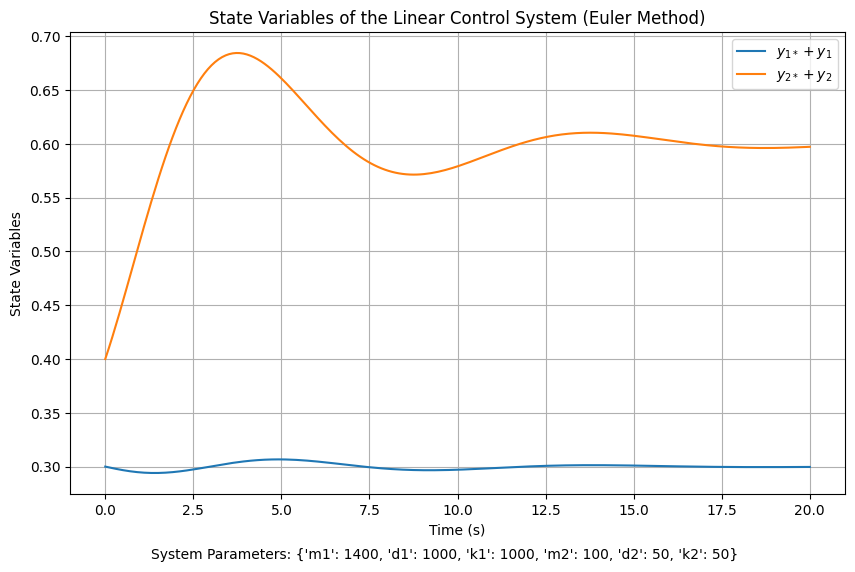

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [2]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 50, "k2": 50}


initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": -0.2} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()


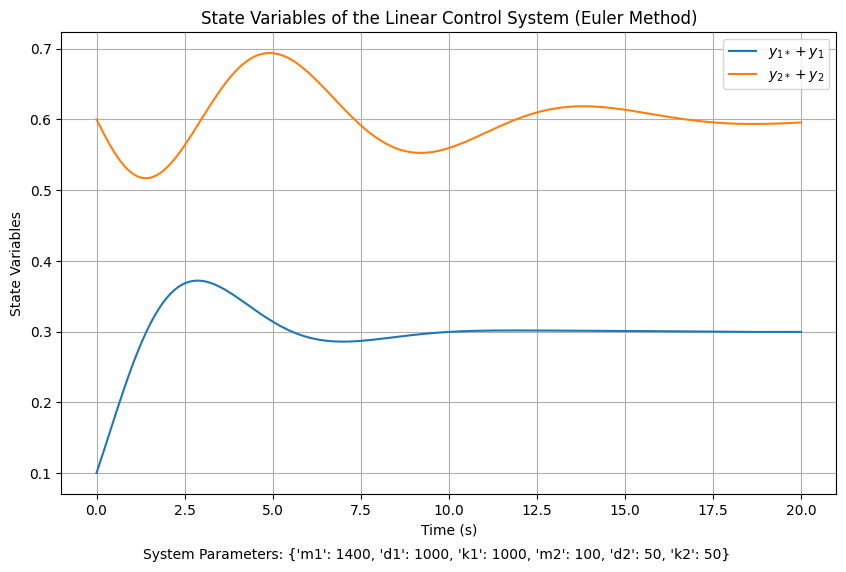

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [3]:
u = lambda t: 0
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 4

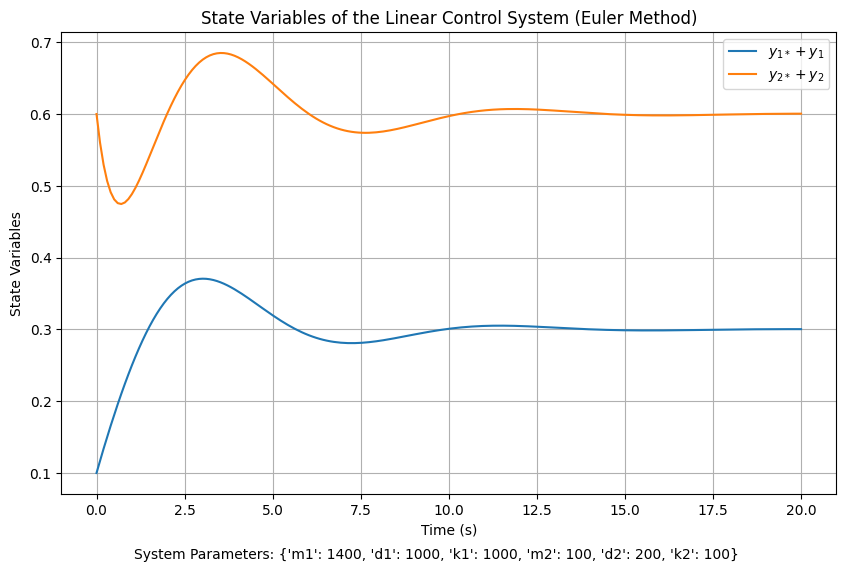

Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [4]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 5

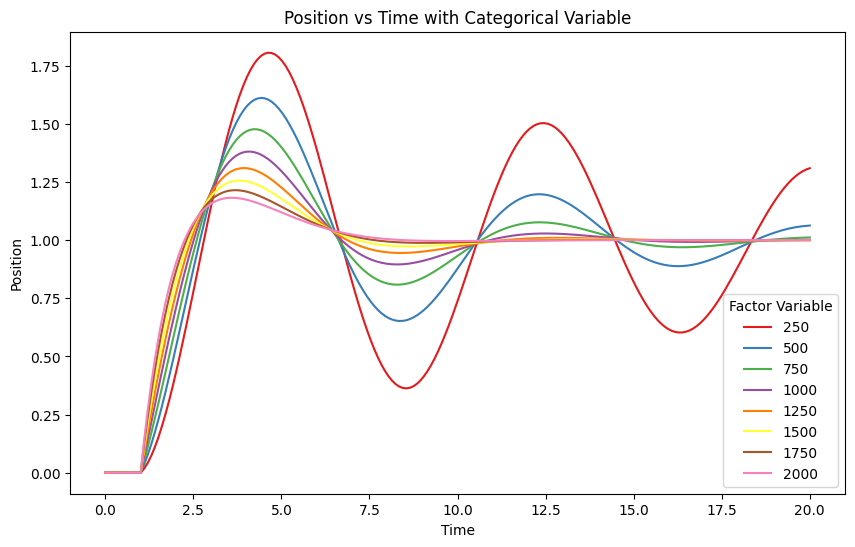

In [5]:
u = lambda t: 0 if t<1 else 1
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

df_list = []

for d1 in np.arange(250,2000+1,250):

    input_parameters = {"m1":1400, "d1": d1, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
    model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
    model.solve(initial_conditions)
    df = model.get_y1()
    df_list.append(df)

df = pd.concat(df_list)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='time_steps', y='y1', hue='d1', palette='Set1')

plt.title('Position vs Time with Categorical Variable')
plt.xlabel('Time')
plt.ylabel('Position')

plt.legend(title='Factor Variable')
plt.show()

# Assignment 6

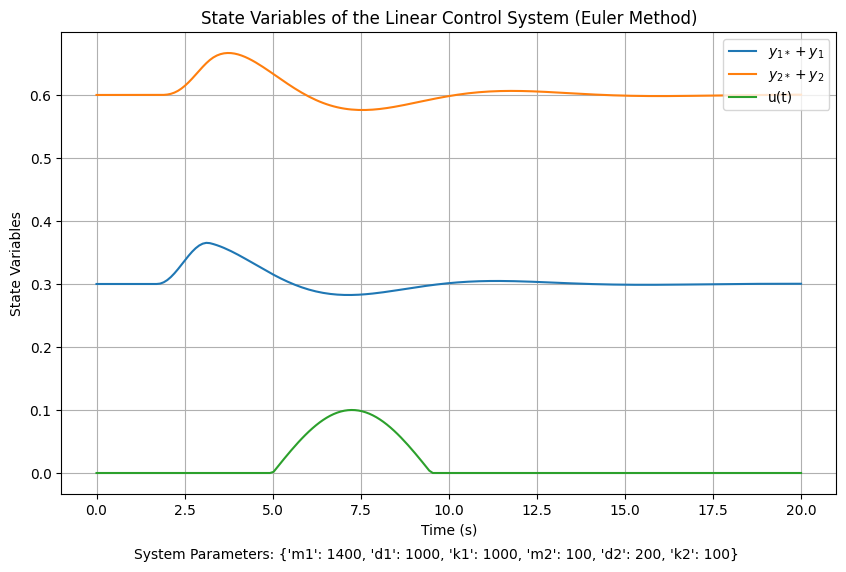

Maximum Elevation Difference (y2 - y1): 0.0211 m
Time of Maximum Elevation: t = 4.5226 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [6]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 7

Bump s=1.5

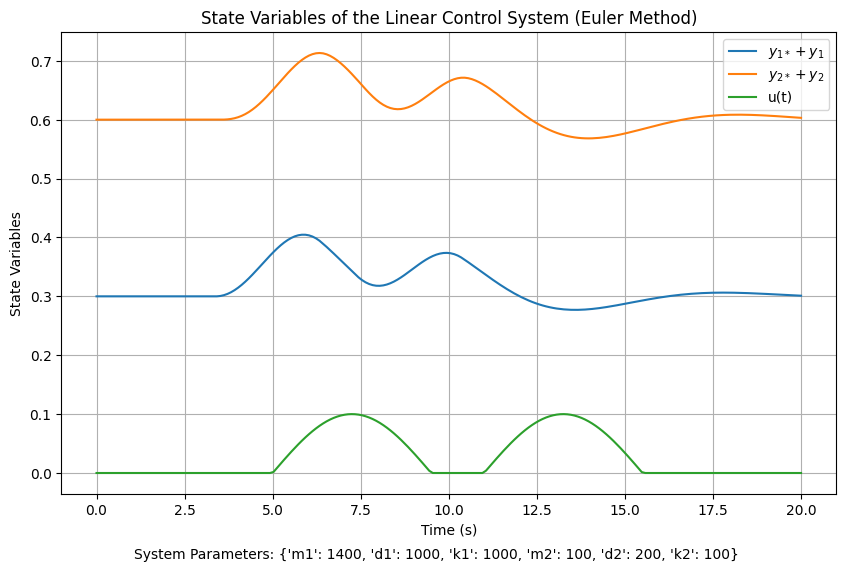

Maximum Elevation Difference (y2 - y1): 0.0352 m
Time of Maximum Elevation: t = 7.1357 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [7]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 1.5*t

u_s1_5 = lambda z: 0.1 * np.cos(-0.6981*(z-7.25-(4.5+1.5))) if 11 <= z <= 15.5 else 0
u_sum1_5 = lambda z: u(z)+u_s1_5(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum1_5, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Bump s=0

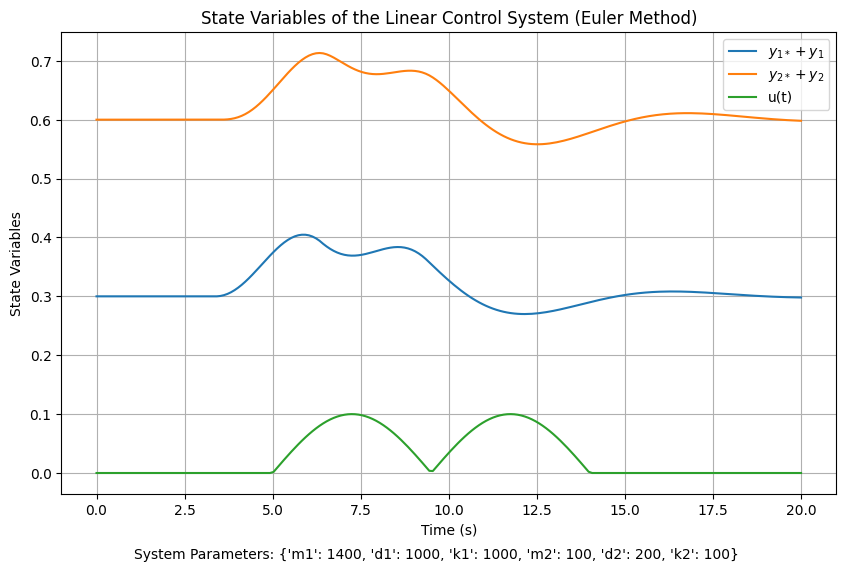

Maximum Elevation Difference (y2 - y1): 0.0282 m
Time of Maximum Elevation: t = 6.7337 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [8]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 1.5*t

u_s0 = lambda z: 0.1 * np.cos(-0.6981*(z-7.25-(4.5))) if 9.5 <= z <= 14 else 0
u_sum0 = lambda z: u(z)+u_s0(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum0, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 8

Speed = 3m/s

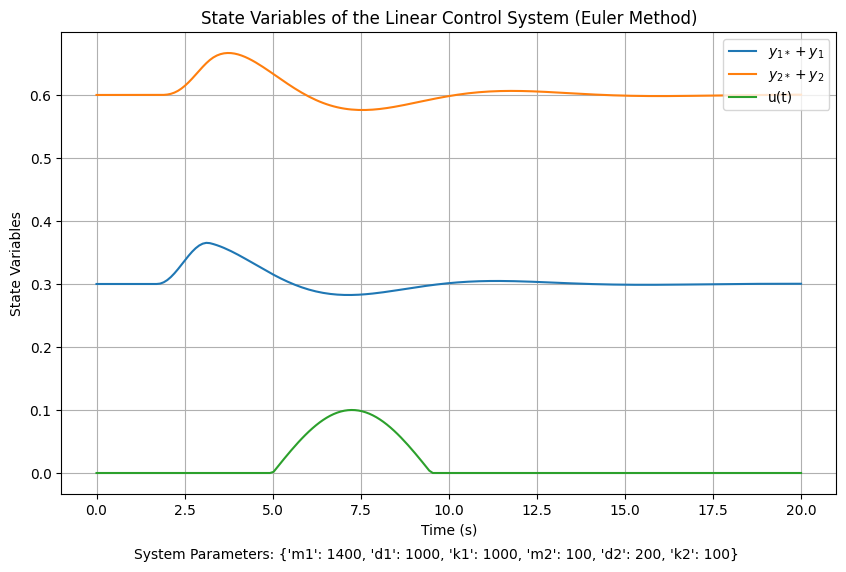

Maximum Elevation Difference (y2 - y1): 0.0211 m
Time of Maximum Elevation: t = 4.5226 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [9]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Speed = 10 m/s

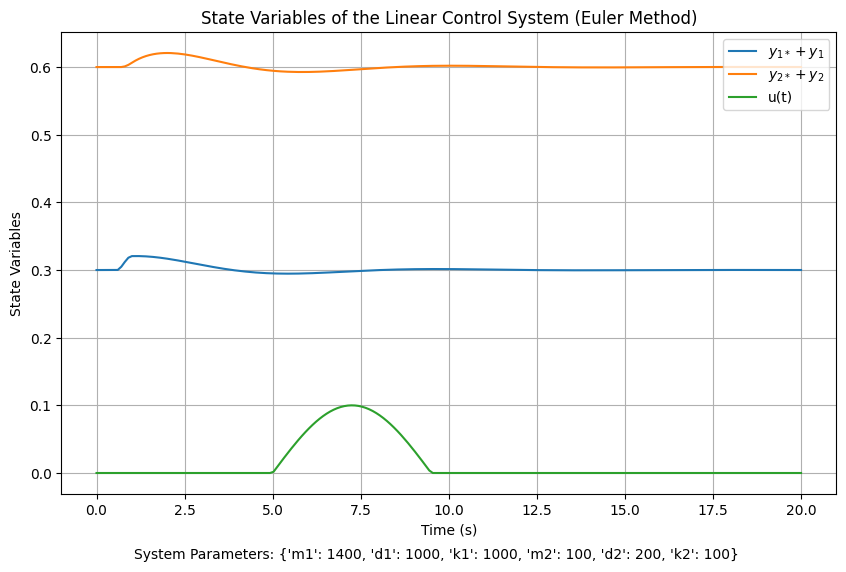

Maximum Elevation Difference (y2 - y1): 0.0066 m
Time of Maximum Elevation: t = 2.7136 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [10]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 10*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 9

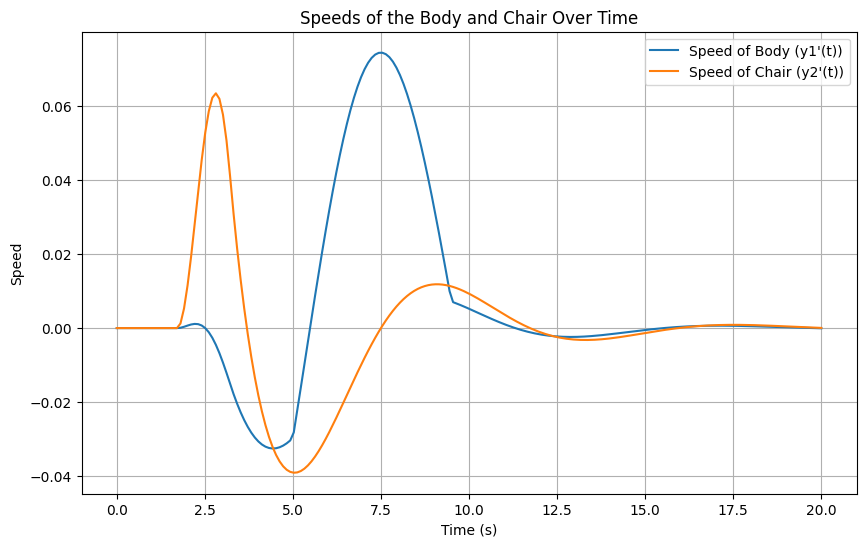

Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [11]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0}


model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)

speeds = model.compute_speeds()

plt.figure(figsize=(10, 6))
plt.plot(model.time_steps, speeds[:, 0], label="Speed of Body (y1'(t))")
plt.plot(model.time_steps, speeds[:, 1], label="Speed of Chair (y2'(t))")
plt.xlabel("Time (s)")
plt.ylabel("Speed")
plt.title("Speeds of the Body and Chair Over Time")
plt.legend()
plt.grid()
plt.show()
model.compute_eigenvalues()